In [1]:
# ============================================================
# SETUP — Run this first!
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import random

# Verify versions
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version:      {np.__version__}")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ GPU available: {gpus[0].name}")
else:
    print("\n⚠️  No GPU detected. Go to Runtime → Change runtime type → T4 GPU")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

TensorFlow version: 2.16.2
NumPy version:      1.26.4

✅ GPU available: /physical_device:GPU:0
Num GPUs Available:  1


In [2]:
import kagglehub

dataset_path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print(f"Dataset downloaded to: {dataset_path}")

# Print structure to understand folder layout
print("\nDataset structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = '  ' * level
    print(f"{indent}{os.path.basename(root)}/  ({len(files)} files)")
    if level >= 3:
        continue


Dataset downloaded to: /Users/mpersson/.cache/kagglehub/datasets/mahmoudreda55/satellite-image-classification/versions/1

Dataset structure:
1/  (1 files)
  data/  (1 files)
    cloudy/  (1500 files)
    water/  (1500 files)
    green_area/  (1500 files)
    desert/  (1092 files)


In [3]:
import hashlib

def file_hash(path, chunk_size=8192):
    hasher = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            hasher.update(chunk)
    return hasher.hexdigest()

seen = {}
duplicates = []

for root_dir, _, file_list in os.walk(dataset_path):
    for fname in file_list:
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        fpath = os.path.join(root_dir, fname)
        h = file_hash(fpath)
        if h in seen:
            duplicates.append(fpath)
        else:
            seen[h] = fpath

for dup in duplicates:
    os.remove(dup)

print(f"Total images scanned: {len(seen) + len(duplicates)}")
print(f"Duplicates removed: {len(duplicates)}")
print(f"Unique images remaining: {len(seen)}")

Total images scanned: 5592
Duplicates removed: 0
Unique images remaining: 5592


In [4]:
data_dir = os.path.join(dataset_path, "data")

batch_size = 32
img_size = (64, 64)
seed = 42

full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)
class_names = full_ds.class_names
print("Class names:", class_names)

# Inspect a single batch
for images, labels in full_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

# Class distribution in full_ds
num_classes = len(class_names)
class_counts = np.zeros(num_classes, dtype=int)

for _, labels in full_ds:
    class_counts += np.bincount(labels.numpy(), minlength=num_classes)

for name, count in zip(class_names, class_counts):
    print(f"{name}: {count}")

full_ds = full_ds.shuffle(1000, seed=seed, reshuffle_each_iteration=False)

total_batches = tf.data.experimental.cardinality(full_ds).numpy()
test_batches = max(1, total_batches // 10)
val_batches = max(1, total_batches // 10)

test_ds = full_ds.take(test_batches)
val_ds = full_ds.skip(test_batches).take(val_batches)
train_ds = full_ds.skip(test_batches + val_batches)

print(f"Train batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Val batches:   {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches:  {tf.data.experimental.cardinality(test_ds).numpy()}")

Found 5592 files belonging to 4 classes.
Class names: ['cloudy', 'desert', 'green_area', 'water']
Images batch shape: (32, 64, 64, 3)
Labels batch shape: (32,)


2026-02-14 17:19:11.494291: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-02-14 17:19:11.494326: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-14 17:19:11.494334: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2026-02-14 17:19:11.494351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-14 17:19:11.494359: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2026-02-14 17:19:11.542696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


cloudy: 1500
desert: 1092
green_area: 1500
water: 1500
Train batches: 141
Val batches:   17
Test batches:  17


2026-02-14 17:19:11.715458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2026-02-14 17:19:11.900956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Images batch shape: (32, 64, 64, 3)
Labels batch shape: (32,)
cloudy: 1193
desert: 891
green_area: 1207
water: 1213


2026-02-14 17:19:12.090651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


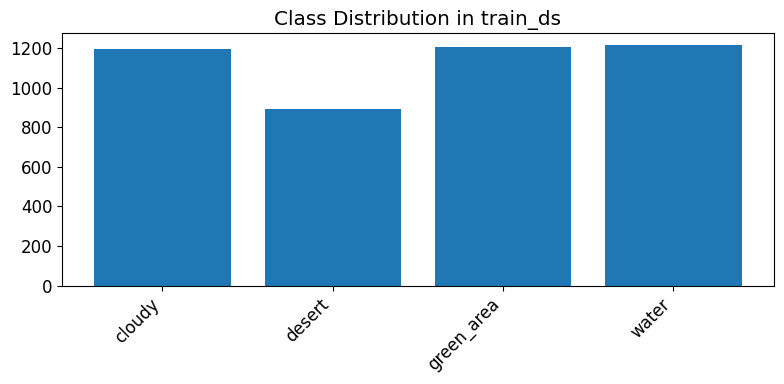

2026-02-14 17:19:12.534129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


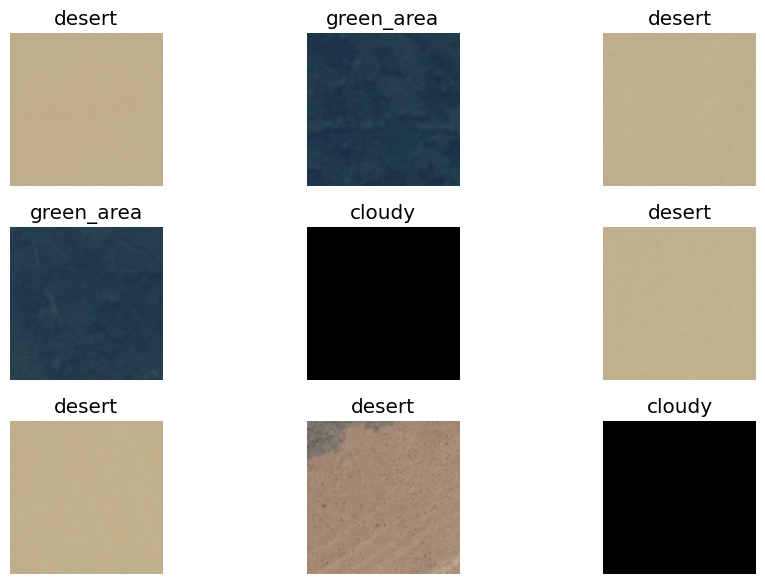

In [5]:
# Basic EDA on train_ds: batch shapes and class distribution


# Inspect a single batch
for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

# Class distribution in train_ds
num_classes = len(class_names)
class_counts = np.zeros(num_classes, dtype=int)

for _, labels in train_ds:
    class_counts += np.bincount(labels.numpy(), minlength=num_classes)

for name, count in zip(class_names, class_counts):
    print(f"{name}: {count}")

# Plot class distribution
plt.figure(figsize=(8, 4))
plt.bar(class_names, class_counts)
plt.title("Class Distribution in train_ds")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Visualize a few sample images
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
# Optimize data pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print("✅ Data pipeline optimized")

✅ Data pipeline optimized


/Users/mpersson/COMP9130/week6/mini-project-5/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,716 (2.61 MB)

 Trainable params: 683,716 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2026-02-14 17:19:12.945118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8264 - loss: 0.7802 - val_accuracy: 0.9173 - val_loss: 0.1972
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8806 - loss: 0.2650 - val_accuracy: 0.8989 - val_loss: 0.3585
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8448 - loss: 0.3627 - val_accuracy: 0.8860 - val_loss: 0.2317
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8355 - loss: 1.2071 - val_accuracy: 0.7040 - val_loss: 12.7658
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7400 - loss: 3.0363 - val_accuracy: 0.8456 - val_loss: 0.3274
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8115 - loss: 0.4714 - val_accuracy: 0.7831 - val_loss: 0.3406
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8379 - loss: 0.3701 - val_accuracy: 0.8658 - val_loss: 0.2569
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8519 - loss: 0.3486 - val_accuracy: 0.86

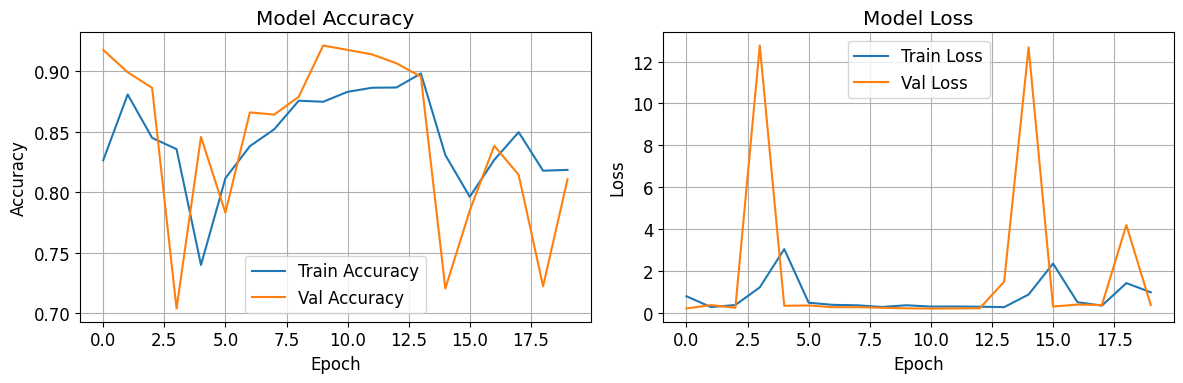

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7941 - loss: 0.4078

Test Accuracy: 0.7941
Test Loss: 0.4078


In [7]:
# Build CNN model
model_basic = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_basic.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model_basic.summary()

# Train the model
history_basic = model_basic.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_basic.history['accuracy'], label='Train Accuracy')
plt.plot(history_basic.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_basic.history['loss'], label='Train Loss')
plt.plot(history_basic.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model_basic.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

2026-02-14 17:19:54.628112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


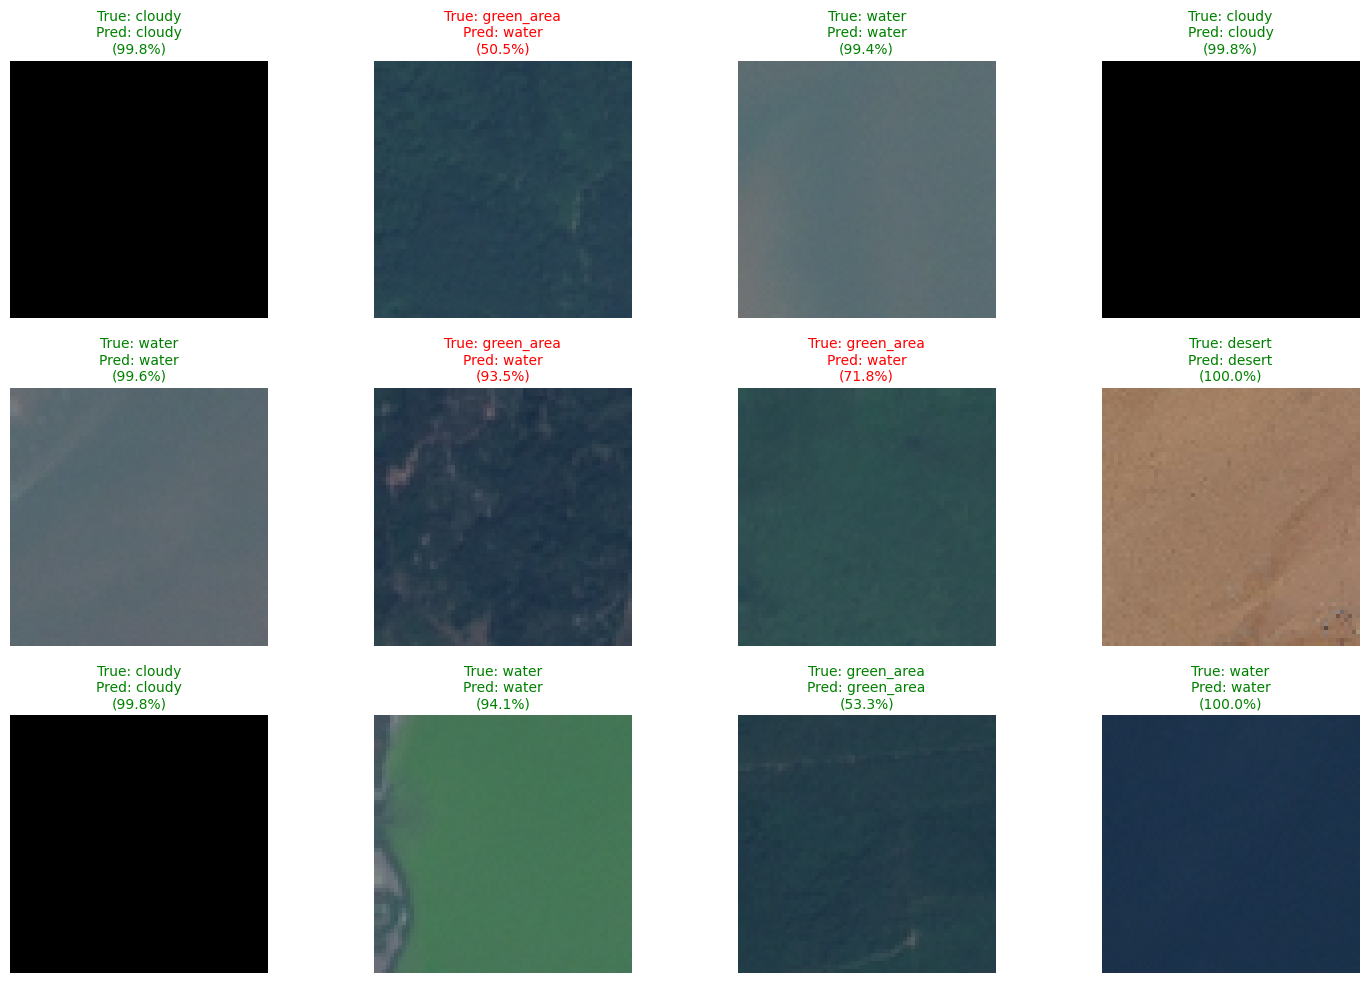

In [8]:
# Get predictions on test set
plt.figure(figsize=(15, 10))

# Get one batch from test set
for images_batch, labels_batch in test_ds.take(1):
    predictions = model_basic.predict(images_batch, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Display 12 images
    for i in range(min(12, len(images_batch))):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        
        true_label = class_names[labels_batch[i]]
        pred_label = class_names[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]] * 100
        
        # Color: green if correct, red if incorrect
        color = 'green' if labels_batch[i] == predicted_classes[i] else 'red'
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)", 
                  color=color, fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()

/Users/mpersson/COMP9130/week6/mini-project-5/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,812 (671.14 KB)

 Trainable params: 171,588 (670.27 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8581 - loss: 0.7952 - val_accuracy: 0.2794 - val_loss: 6.0843
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8888 - loss: 0.8072 - val_accuracy: 0.2794 - val_loss: 8.5302
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9143 - loss: 0.6547 - val_accuracy: 0.8070 - val_loss: 1.4868
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8950 - loss: 0.8706 - val_accuracy: 0.7555 - val_loss: 5.8745
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9347 - loss: 0.5530 - val_accuracy: 0.9007 - val_loss: 0.7573
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9365 - loss: 0.5232 - val_accuracy: 0.8952 - val_loss: 0.4864
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9558 - loss: 0.3784 - val_accuracy: 0.9688 - val_loss: 0.1362
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9583 - loss: 0.3082 - val_accu

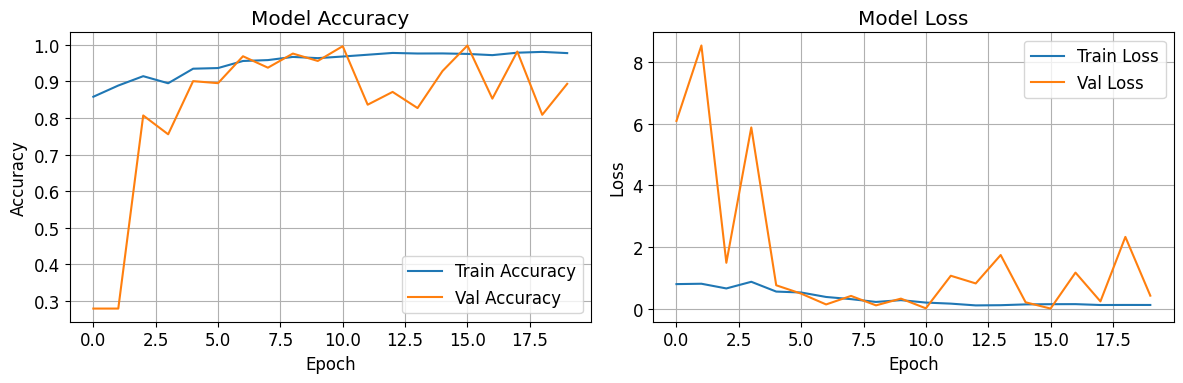

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8713 - loss: 0.5760

Test Accuracy: 0.8713
Test Loss: 0.5760


In [ ]:
# Build CNN model
model_augmented = models.Sequential([

    layers.Rescaling(1./255, input_shape=(64, 64, 3)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    # First convolutional block
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_augmented.compile(
    optimizer='adamw',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model_augmented.summary()

# Train the model
history_augmented = model_augmented.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['accuracy'], label='Train Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['loss'], label='Train Loss')
plt.plot(history_augmented.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model_augmented.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

2026-02-14 17:21:10.627882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


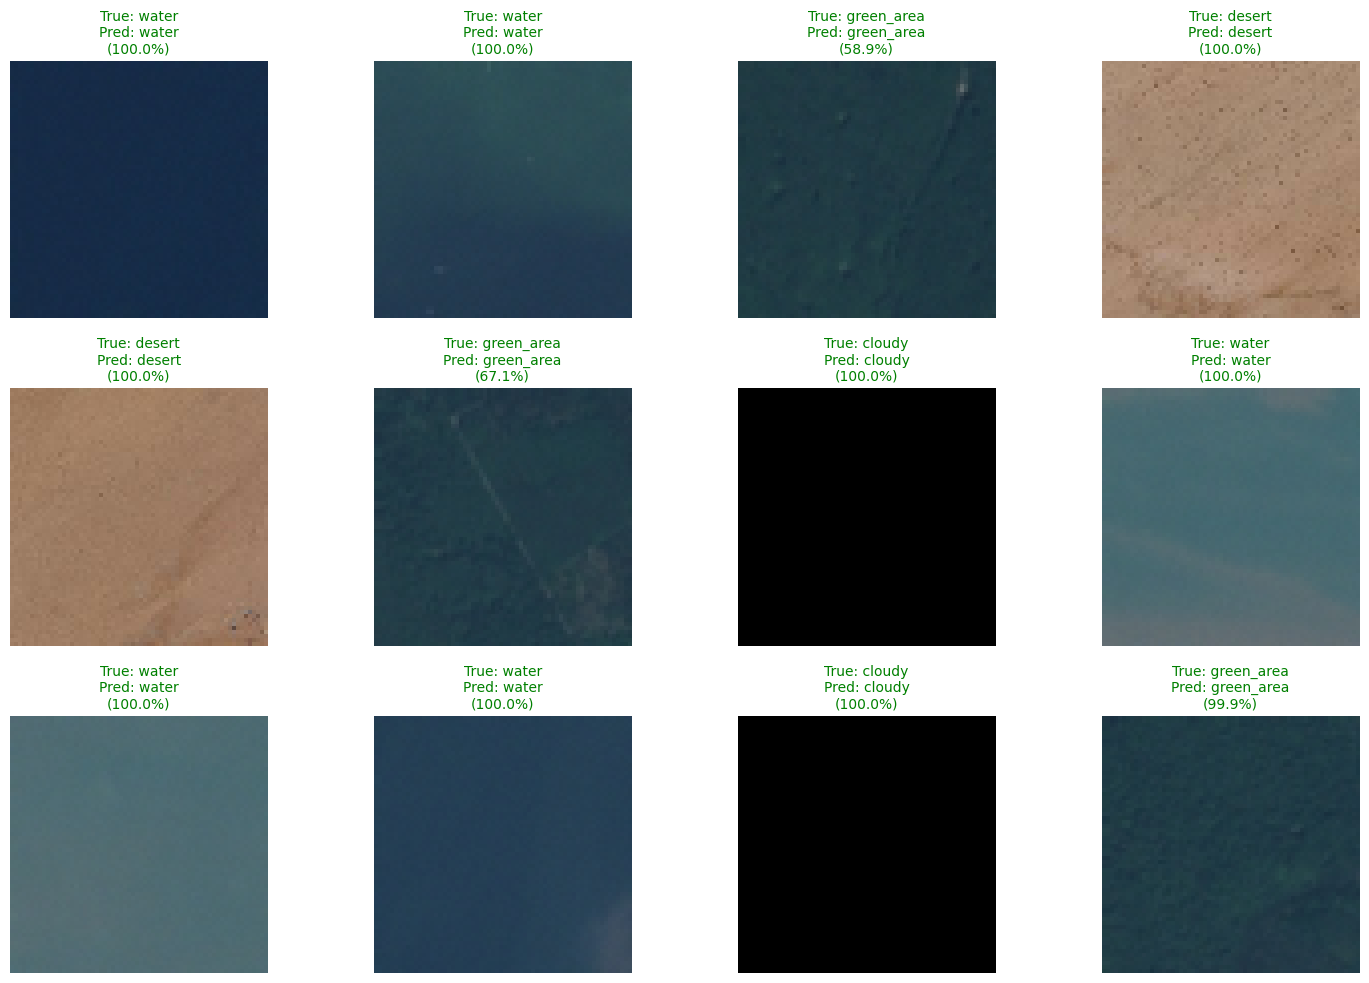

In [10]:
# Get predictions on test set
plt.figure(figsize=(15, 10))

# Get one batch from test set
for images_batch, labels_batch in test_ds.take(1):
    predictions = model_augmented.predict(images_batch, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Display 12 images
    for i in range(min(12, len(images_batch))):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        
        true_label = class_names[labels_batch[i]]
        pred_label = class_names[predicted_classes[i]]
        confidence = predictions[i][predicted_classes[i]] * 100
        
        # Color: green if correct, red if incorrect
        color = 'green' if labels_batch[i] == predicted_classes[i] else 'red'
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)", 
                  color=color, fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()